In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import braycurtis
import plotly_express as px
from pyvis.network import Network

In [21]:
data_df = pd.read_csv(r"C:\Users\tomer\Desktop\year3\sem B\workshop_microbiome\train_data.csv", index_col="sample")
metadata_df = pd.read_csv(r"C:\Users\tomer\Desktop\year3\sem B\workshop_microbiome\train_metadata.csv",  index_col="sample")

In [22]:
data_df

,g_[Eubacterium]_coprostanoligenes_group,g_[Eubacterium]_hallii_group,g_[Eubacterium]_ruminantium_group,g_Acidaminococcus,g_Alloprevotella,g_Bifidobacterium,g_Butyricicoccus,g_CAG-873,g_Campylobacter,g_Candidatus_Methanogranum,...,g_Ruminococcaceae_UCG-011,g_Ruminococcaceae_UCG-013,g_Ruminococcaceae_UCG-014,g_Ruminococcus_1,g_Senegalimassilia,g_Slackia,g_Solobacterium,g_Streptococcus,g_Succinivibrio,g_Treponema_2
sample,,,,,,,,,,,,,,,,,,,,,
sample_11406-GCGAGGAAGTCC-394,0.016003,0.000000,0.014068,0.019258,0.003619,0.077623,0.000592,0.007876,0.000114,0.094286,...,0.000000,0.005782,0.049215,0.022285,0.000091,0.000000,0.000455,0.000091,0.000137,0.030139
sample_11406-AACTTTCAGGAG-394,0.031825,0.008014,0.000563,0.000000,0.043680,0.003456,0.002714,0.010907,0.000256,0.035589,...,0.001997,0.011547,0.022608,0.015439,0.000819,0.003226,0.004916,0.000000,0.032056,0.000000
sample_11406-CCAGGACAGGAA-394,0.039359,0.026135,0.001454,0.000000,0.070964,0.005781,0.000000,0.000242,0.000000,0.050955,...,0.002873,0.005919,0.002319,0.017516,0.000554,0.000935,0.001765,0.000277,0.009173,0.048048
sample_11406-GTCGCTTGCACA-394,0.026817,0.007681,0.006232,0.000000,0.078344,0.002897,0.008164,0.000000,0.000176,0.022867,...,0.000571,0.007900,0.010885,0.014396,0.001097,0.001756,0.002721,0.001141,0.005794,0.000000
sample_11406-TCCGCCTAGTCG-394,0.040233,0.003025,0.007546,0.000000,0.051616,0.001659,0.001984,0.000098,0.009725,0.000000,...,0.000260,0.022767,0.033891,0.030801,0.000650,0.001008,0.000423,0.000000,0.005236,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_12053-TTGGACGTCCAC-409,0.023016,0.001397,0.006103,0.003199,0.010626,0.102949,0.001324,0.000846,0.000772,0.073682,...,0.000956,0.008089,0.022281,0.042319,0.000772,0.000699,0.001985,0.000368,0.005331,0.104530
sample_12053-TTGGGAGCGAAG-409,0.034073,0.000062,0.000000,0.000310,0.004027,0.049374,0.000000,0.063933,0.008549,0.109466,...,0.003407,0.004460,0.067340,0.039524,0.000062,0.000124,0.000805,0.000000,0.000000,0.066535
sample_12053-TTGGGCCACATA-409,0.006261,0.000225,0.004369,0.005540,0.006621,0.201703,0.000045,0.026575,0.000045,0.139363,...,0.001216,0.010450,0.054322,0.006756,0.000586,0.000180,0.002297,0.000000,0.000000,0.000495


## basic overview

How many samples do we have from each subject?

we have 80 baboons in the train data
76.2 samples per baboon on average


Text(0.5, 1.0, 'Number of Samples per Baboon - train data')

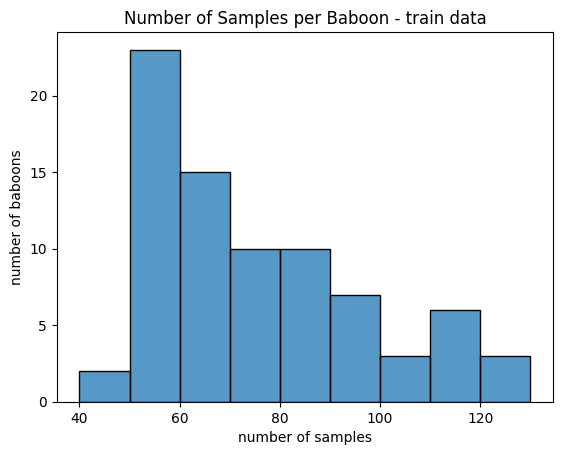

In [23]:
baboons = metadata_df.groupby("baboon_id").count()["collection_date"]
print(f"we have {len(baboons)} baboons in the train data")
print(f"{baboons.mean()} samples per baboon on average")
sns.histplot(baboons, binwidth=10, binrange=(40, 130))
plt.xlabel("number of samples")
plt.ylabel("number of baboons")
plt.title("Number of Samples per Baboon - train data")

What is the time difference between them?

In [24]:
metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
metadata_df.sort_values(by=["baboon_id", "collection_date"], inplace=True)
ls = []
ds = []
for baboon in metadata_df["baboon_id"].unique():
    curr = metadata_df[metadata_df["baboon_id"] == baboon]["collection_date"].values
    ls.append(np.nan)
    for i in range(len(curr)-1):
        ds.append(curr[i+1]-curr[i])
        ls.append(curr[i+1]-curr[i])

ds = np.array(ds)

In [25]:
ds[ds>180].size

282

Text(0.5, 0, 'time difference between 2 subsequent samples (days)')

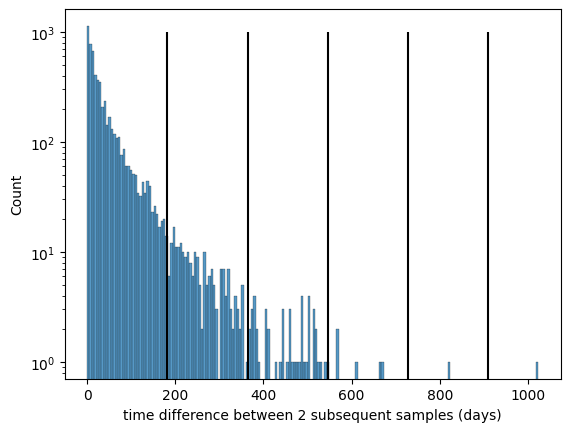

In [26]:
sns.histplot(ds)
max_time = max(ds) 
for i in range(365//2,max_time,365//2):
    plt.vlines(x= i, ymin=0, ymax = 1000, color="black")

plt.yscale("log")
plt.xlabel("time difference between 2 subsequent samples (days)")

In [27]:
indexes_list = set()
visited = set()

for index, row in metadata_df.iterrows():
    if not (index in visited):
        collection_date = row['collection_date']
        baboon_id = row['baboon_id']
        matching_indexes = metadata_df[(metadata_df['collection_date'] == collection_date) & (metadata_df['baboon_id'] == baboon_id)].index.tolist()
        visited.update(matching_indexes)

    indexes_list.add(tuple(matching_indexes))
indexes_list = [list(l) for l in dict.fromkeys([tuple(sorted(indexes)) for indexes in indexes_list])]

In [28]:
from scipy.spatial.distance import braycurtis
import numpy as np
bray_curtis_distances = []

for indexes in indexes_list:
    for row1 in data_df.loc[indexes].iterrows():
        for row2 in data_df.loc[indexes].iterrows():
            if row1[0] != row2[0]:
                distance = braycurtis(row1[1], row2[1])
                bray_curtis_distances.append(distance)

bray_curtis_distances = np.array(bray_curtis_distances)
sns.kdeplot(bray_curtis_distances)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis Distance Distribution (between same day - same baboon samples)")
plt.vlines(x = bray_curtis_distances.mean(), ymin=0, ymax=4.5, color="red", label=f"mean ({np.around(np.mean(bray_curtis_distances),3)})")
plt.vlines(x = np.median(bray_curtis_distances), ymin=0, ymax=4.5, color="green", label=f"median ({np.around(np.quantile(bray_curtis_distances, 0.5),3)})")



lower_bound = np.quantile(bray_curtis_distances, 0.025)
upper_bound = np.quantile(bray_curtis_distances, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=4.5, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=4.5, color="blue")



plt.legend()
plt.show()

KeyboardInterrupt: 

## Microbiome Ordination

Calculate Bray-Curtis distances between all microbiome samples and plot PCoA

In [ ]:
d = {baboon : i for i,baboon in enumerate(metadata_df["baboon_id"].unique())}
lables = [d[baboon] for baboon in metadata_df.loc[data_df.index]["baboon_id"].values]


In [ ]:
dist_matrix = beta_diversity(braycurtis, data_df.values)
ordination = pcoa(dist_matrix)
pc_scores = ordination.samples
pc_scores

c:\Users\tomer\AppData\Local\Programs\Python\Python311\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -16.69549737613822 and the largest is 307.0741493384899.
  warn(


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC6087,PC6088,PC6089,PC6090,PC6091,PC6092,PC6093,PC6094,PC6095,PC6096
0,-0.284371,0.017998,0.166362,0.027146,0.036911,0.108028,-0.063975,0.031770,0.200539,0.053125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.317647,-0.292575,-0.118535,0.058171,-0.005837,0.042558,-0.022280,-0.116310,0.033092,0.000107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.275095,-0.378010,-0.150778,0.035183,-0.048386,-0.028815,-0.077729,-0.016332,0.088168,0.008321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.263374,-0.433144,-0.131062,0.089837,-0.013380,-0.023801,-0.033265,-0.057304,0.018703,0.050513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.243190,-0.509317,-0.134562,0.096025,-0.075489,0.002043,-0.052563,0.026472,0.011020,0.094392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,-0.292800,0.024511,-0.048979,0.068938,0.004110,0.057039,-0.053397,-0.070448,0.005406,-0.015917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6092,-0.439322,0.252916,-0.192676,-0.051092,0.028712,-0.008673,-0.011105,0.118853,0.048470,-0.023904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6093,-0.207374,0.102777,-0.023770,-0.023539,-0.052144,-0.059208,0.023742,-0.029103,-0.023351,0.078630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6094,0.228994,0.090267,0.001599,-0.026259,-0.021712,0.040530,-0.023352,0.060769,0.067084,0.025747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
px.scatter_3d(pc_scores.iloc[:,:3], x="PC1", y="PC2", z="PC3", color=lables)


In [29]:
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])

In [ ]:
microbiom_with_sample_data

,g_[Eubacterium]_coprostanoligenes_group,g_[Eubacterium]_hallii_group,g_[Eubacterium]_ruminantium_group,g_Acidaminococcus,g_Alloprevotella,g_Bifidobacterium,g_Butyricicoccus,g_CAG-873,g_Campylobacter,g_Candidatus_Methanogranum,...,g_Ruminococcaceae_UCG-014,g_Ruminococcus_1,g_Senegalimassilia,g_Slackia,g_Solobacterium,g_Streptococcus,g_Succinivibrio,g_Treponema_2,baboon_id,collection_date
sample,,,,,,,,,,,,,,,,,,,,,
sample_12050-GAATATACCTGG-407,0.092278,0.001774,0.001412,0.000000,0.017377,0.232994,0.000471,0.000724,0.001050,0.003186,...,0.029468,0.008833,0.000652,0.002100,0.002027,0.002389,0.001520,0.000000,Baboon_101,11445
sample_12050-CGGCCTAAGTTC-407,0.054978,0.000000,0.000340,0.001171,0.023843,0.504515,0.000340,0.013716,0.000000,0.001058,...,0.002418,0.002456,0.002116,0.001096,0.001323,0.000189,0.002116,0.000000,Baboon_101,11461
sample_12050-TAGACTTCAGAG-407,0.011303,0.000345,0.000000,0.001256,0.056138,0.367316,0.000000,0.000345,0.000157,0.012559,...,0.000000,0.009325,0.000000,0.000973,0.000816,0.000188,0.000754,0.000000,Baboon_101,11465
sample_12051-CACTAACAAACG-408,0.002081,0.000000,0.001596,0.000416,0.021021,0.411044,0.003920,0.024004,0.004752,0.098477,...,0.014118,0.001977,0.000416,0.000000,0.000520,0.000000,0.000000,0.000000,Baboon_101,11533
sample_11413-CGGGCGAATTGG-397,0.001270,0.000000,0.000614,0.003072,0.001147,0.574922,0.004506,0.004875,0.000000,0.076602,...,0.007578,0.005694,0.001393,0.000369,0.001680,0.000000,0.001925,0.000451,Baboon_101,11540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_11413-AGCCCGCAAAGG-397,0.018133,0.003507,0.003905,0.003387,0.002351,0.514167,0.000000,0.012792,0.002311,0.023393,...,0.053202,0.012753,0.000598,0.000917,0.001634,0.000638,0.025744,0.000000,Baboon_96,14870
sample_11410-AGTTCATACGGC-396,0.001174,0.034483,0.000000,0.001483,0.002348,0.442838,0.002719,0.000000,0.000185,0.001298,...,0.001236,0.002781,0.051292,0.049438,0.058954,0.023792,0.012977,0.000433,Baboon_96,14954
sample_12053-TGTACGGATAAC-409,0.002579,0.004087,0.002420,0.008650,0.010793,0.683954,0.000754,0.000198,0.003214,0.000675,...,0.000476,0.006706,0.001389,0.003254,0.008412,0.002936,0.003095,0.000119,Baboon_96,14988


In [ ]:
ls = []
days =[]
label = []
for idx in range(len(microbiom_with_sample_data)-1):
    curr = microbiom_with_sample_data.iloc[[idx]].values.reshape(-1)
    next = microbiom_with_sample_data.iloc[[idx+1]].values.reshape(-1)
    if(curr[-2] == next[-2]):    
        ls.append(braycurtis(curr[:-2],next[:-2]))
        label.append(curr[-2])
        days.append(next[-1] - curr[-1])
ls = np.array(ls)

In [ ]:
print(f"calculate average distance between subsequent samples: {ls.mean()}")

calculate average distance between subsequent samples: 0.3949177595644591


In [ ]:
ls = np.array(ls)
sns.kdeplot(ls)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis KDE (mean of previous vs current sample)")
plt.vlines(x = ls.mean(), ymin=0, ymax=2.5, color="red", label="mean")
plt.vlines(x = np.median(ls), ymin=0, ymax=2.5, color="green", label="median")



lower_bound = np.quantile(ls, 0.025)
upper_bound = np.quantile(ls, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=2.5, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=2.5, color="blue")

plt.legend()
plt.show()

NameError: name 'np' is not defined

In [ ]:
mean_baboon = microbiom_with_sample_data.groupby("baboon_id").mean()
mean_baboon.drop(columns=["collection_date"], inplace=True)

bc_scores = []
for baboon in mean_baboon.index:
    baboon_samples = metadata_df[metadata_df["baboon_id"]==baboon].index
    for i in range(1, len(baboon_samples)):
        mean_previous = data_df.loc[baboon_samples[0:i]].mean().values
        bc_scores.append(braycurtis(mean_previous, data_df.loc[baboon_samples[i]].values))

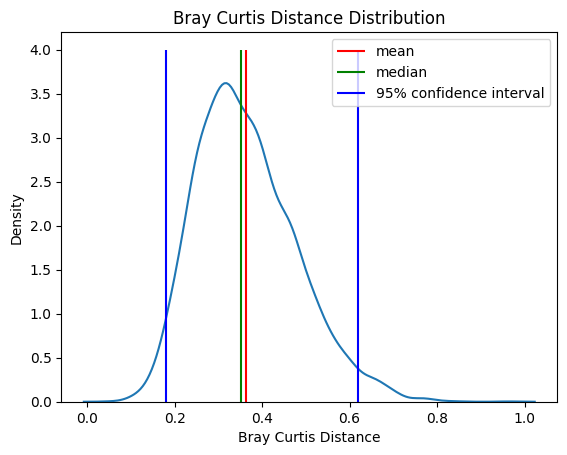

In [ ]:
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis Distance Distribution")
plt.vlines(x = bc_scores.mean(), ymin=0, ymax=4, color="red", label="mean")
plt.vlines(x = np.median(bc_scores) , ymin=0, ymax=4, color="green", label="median")



lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=4, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=4, color="blue")

plt.legend()
plt.show()

In [ ]:
import networkx as nx
import plotly.graph_objects as go
corr = imports.clr_normalization(data_df).corr('spearman')
corr = corr - np.eye(corr.shape[0])
# corr.to_csv("corr.csv")
corr = corr.map(lambda x: abs(x))
px.imshow(corr, color_continuous_scale='viridis', width=800, height=800)

In [ ]:
G = nx.from_pandas_adjacency(corr.map(lambda x: 1 if x > 0.5 else 0))
g = Network(height="750px", width="100%", notebook=True, cdn_resources='remote')
g.toggle_hide_edges_on_drag(False)
g.barnes_hut()
g.from_nx(G)
g.show("graph2.html")



graph2.html


In [ ]:

cor = corr.map(lambda x: x if x > 0.45 else 0)
# Create a graph from the correlation matrix
G = nx.Graph()

# Add nodes
G.add_nodes_from(cor.index)

# Add edges with weights
for i in range(cor.shape[0]):
    for j in range(i + 1, cor.shape[1]):
        if cor.iloc[i, j] > 0:  # Only add edges for non-zero correlations
            G.add_edge(cor.index[i], cor.index[j], weight=cor.iloc[i, j])

# Prepare positions for plotly layout
pos = nx.spring_layout(G)  # You can use different layout algorithms depending on preference

# Create edge traces
edge_trace = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    weight = G[edge[0]][edge[1]]['weight']
    edge_trace.append(go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        line=dict(width=2, color='#888'),
        hoverinfo='none',
        mode='lines',
        opacity=min(0.5, 0.5 + weight / 2)
    ))

# Create node traces
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)
    )
)

# Populate node and edge traces
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_trace['text'] += (node,)

# Create figure
fig = go.Figure(
    data=edge_trace + [node_trace],
    layout=go.Layout(
        title='<br>Correlation Network Graph',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[dict(
            text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002)],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

# Show plot
fig.show()


In [ ]:
corr = data_df.corr('spearman')
# Assuming 'corr' is your adjacency matrix as a pandas DataFrame
G = nx.from_pandas_adjacency(corr)
partition = nx.community.louvain_communities(G, weight='weight')

# Generate positions
pos = nx.spring_layout(G)

# Create a community map
community_map = {}
for idx, community in enumerate(partition):
    for node in community:
        community_map[node] = idx

# Edge trace
edge_x = []
edge_y = []
edge_weights = []
for edge in G.edges(data=True):
    if (abs(edge[2]['weight']) < 0.5):
        continue
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    edge_weights.append(edge[2]['weight'])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Node trace
node_x = []
node_y = []
node_text = []
node_color = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node} (Community {community_map[node]})")
    node_color.append(community_map[node])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Jet',
        color=node_color,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Community',
            xanchor='left',
            titleside='right'
        ),
        line_width=2),
    text=node_text
)

# Create a figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network graph with community detection',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper") ],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
                )
fig.show()



In [ ]:
corr = data_df.corr('spearman')

In [ ]:
# Assuming 'corr' is your adjacency matrix as a pandas DataFrame
G = nx.from_pandas_adjacency(abs(corr))
partition = nx.community.louvain_communities(G)

In [ ]:
def plot_3d_network(G, pos, community_map, excluded_communities=[]):
    # Generate positions in 3D
    pos = nx.spring_layout(G, dim=3)

    # Create a community map
    community_map = {}
    for idx, community in enumerate(partition):
        for node in community:
            community_map[node] = idx

    # Edge trace
    edge_x = []
    edge_y = []
    edge_z = []
    edge_weights = []
    for edge in G.edges(data=True):
        if (abs(edge[2]['weight']) < 0.5):
            continue
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_z.append(z0)
        edge_z.append(z1)
        edge_z.append(None)
        edge_weights.append(edge[2]['weight'])

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Node trace
    node_x = []
    node_y = []
    node_z = []
    node_text = []
    node_color = []

    for node in G.nodes():
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_text.append(f"{node} (Community {community_map[node]})")
        node_color.append(community_map[node])

    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Jet',
            color=node_color,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Community',
                xanchor='left',
                titleside='right'
            ),
            line_width=2),
        text=node_text
    )

    # Create a figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='3D Network graph with community detection',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        scene=dict(
                            xaxis=dict(showgrid=False, zeroline=False),
                            yaxis=dict(showgrid=False, zeroline=False),
                            zaxis=dict(showgrid=False, zeroline=False))
                        )
                    )


    return fig
